In [2]:
!pip install ktrain==0.32.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 35.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 77.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 653.6/653.6 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 98.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 kB 54.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 73.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for ktrain: filename=ktrain-0.32.3-py3-non

In [3]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import re
import string
import ktrain
from ktrain import text
import timeit
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
import nltk
nltk.download('punkt')  # for tokenization
from nltk.stem import PorterStemmer


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [6]:
# Load the data
testpath = '/content/test.csv'
trainingpath = '/content/train.csv'
train = pd.read_csv(trainingpath)
test = pd.read_csv(testpath)

In [7]:
def clean_text(text):
    stemmer = PorterStemmer()
    text = str(text).lower()  # Convert text to lowercase
    text = re.sub('\d+', '', text)  # Remove numbers
    text = re.sub('\[.*?\]', '', text)  # Remove HTML tags
    text = re.sub('https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)  # Remove punctuation
    # Tokenize text
    tokens = nltk.word_tokenize(text)
    # Stemming and stopwords removal
    stemmed_tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return ' '.join(stemmed_tokens)

In [8]:
# Encode labels
label_encoder = LabelEncoder()
train['Class Index'] = label_encoder.fit_transform(train['Class Index'])
test['Class Index'] = label_encoder.transform(test['Class Index'])

In [9]:
# Initialize the DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [10]:
def encode_texts(tokenizer, texts, max_len=256):
    input_ids = []
    attention_masks = []
    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='tf',
        )
        # Ensure the tensors are squeezed to remove unnecessary dimensions
        input_ids.append(tf.squeeze(encoded['input_ids']))
        attention_masks.append(tf.squeeze(encoded['attention_mask']))
    return np.array(input_ids), np.array(attention_masks)

In [11]:
# Encode the text data
X_train_ids, X_train_masks = encode_texts(tokenizer, train['Description'].values, max_len=128)
X_test_ids, X_test_masks = encode_texts(tokenizer, test['Description'].values, max_len=128)

In [12]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
# Convert labels to one-hot encoding
y_train = to_categorical(train['Class Index'].values)
y_test = to_categorical(test['Class Index'].values)

In [13]:
# Load the DistilBERT model
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(label_encoder.classes_))

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

In [14]:
# Prepare the model for training
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [15]:
from tensorflow.keras.callbacks import TensorBoard

# Set up the TensorBoard callback
tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1)

In [16]:
# Training the model
history = model.fit(
    [X_train_ids, X_train_masks],
    y_train,
    epochs=3,
    batch_size=64,
    validation_data=([X_test_ids, X_test_masks], y_test),
    callbacks=[tensorboard_callback]  # Add the TensorBoard callback here
)

Epoch 1/3
1875/1875 [==============================] - 1447s 761ms/step - loss: 0.2442 - accuracy: 0.9181 - val_loss: 0.1840 - val_accuracy: 0.9339
Epoch 2/3
1875/1875 [==============================] - 1422s 759ms/step - loss: 0.1438 - accuracy: 0.9510 - val_loss: 0.1856 - val_accuracy: 0.9376
Epoch 3/3
1875/1875 [==============================] - 1412s 753ms/step - loss: 0.0966 - accuracy: 0.9667 - val_loss: 0.1929 - val_accuracy: 0.9393


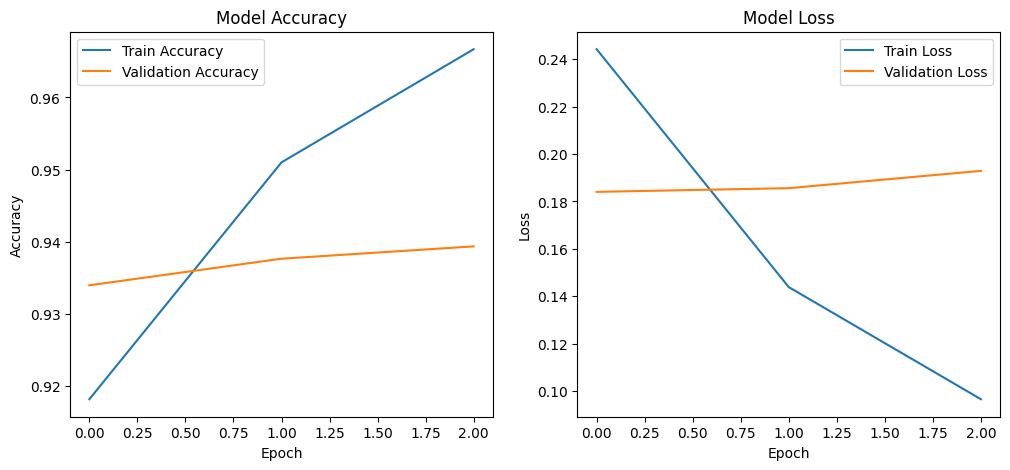

In [17]:
import matplotlib.pyplot as plt

# Plotting training and validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.show()


238/238 [==============================] - 33s 136ms/step


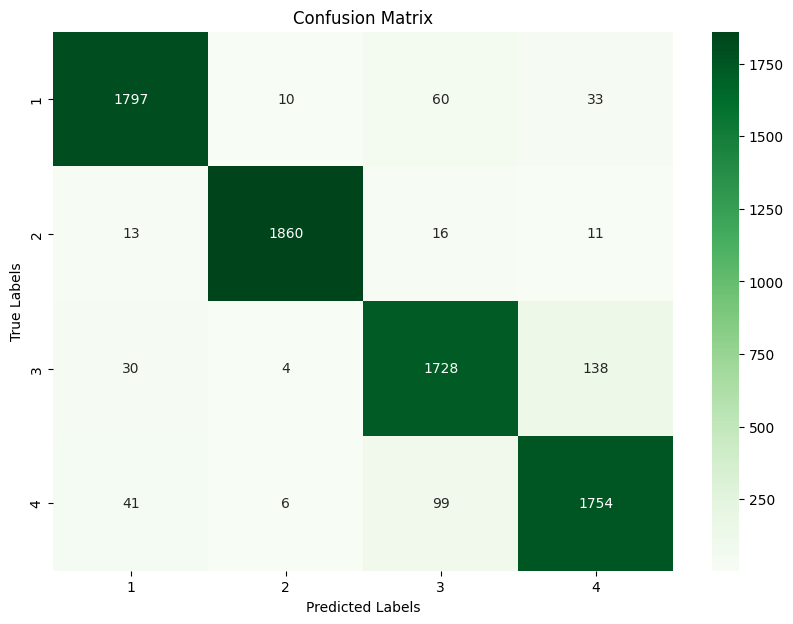

In [23]:
# Predict on the test data
test_pred_logits = model.predict([X_test_ids, X_test_masks])
test_pred = tf.argmax(test_pred_logits.logits, axis=1)

# Convert one-hot encoded test labels back to class indices for comparison
y_test_labels = tf.argmax(y_test, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_test_labels, test_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [19]:
# Convert numeric class indices to strings
target_names = [str(cls) for cls in label_encoder.classes_]

# Generate the classification report
cr = classification_report(y_test_labels, test_pred, target_names=target_names)
print("Classification Report:")
print(cr)

Classification Report:
              precision    recall  f1-score   support

           1       0.96      0.95      0.95      1900
           2       0.99      0.98      0.98      1900
           3       0.91      0.91      0.91      1900
           4       0.91      0.92      0.91      1900

    accuracy                           0.94      7600
   macro avg       0.94      0.94      0.94      7600
weighted avg       0.94      0.94      0.94      7600



In [22]:
import random
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

# Step 1: Sample 30 random descriptions from the test set
random_indices = random.sample(range(test.shape[0]), 30)
sample_test = test.iloc[random_indices]

# Encode the samples
sample_test_ids, sample_test_masks = encode_texts(tokenizer, sample_test['Description'].values, max_len=128)

# Step 2: Predict on these samples
sample_test_pred_logits = model.predict([sample_test_ids, sample_test_masks])
sample_test_pred = tf.argmax(sample_test_pred_logits.logits, axis=1)

# Step 3: Extract the true labels
sample_test_true_labels = tf.argmax(to_categorical(sample_test['Class Index'].values), axis=1)

# Convert predictions and true labels to category names
predictions = label_encoder.inverse_transform(sample_test_pred.numpy())
true_labels = label_encoder.inverse_transform(sample_test_true_labels.numpy())

# Print the comparison
for i, description in enumerate(sample_test['Description']):
    print(f"Description: {description}")
    print(f"Predicted Category: {predictions[i]}")
    print(f"True Category: {true_labels[i]}\n")

1/1 [==============================] - 0s 176ms/step
Description: Reuters - Internet companies and\law-enforcement agencies said on Wednesday they will work\together to track down online scam artists who pose as banks\and other legitimate businesses, a practice known as\"phishing."
Predicted Category: 4
True Category: 4

Description: Hewlett-Packard has signed a deal to sell network adapters from start-up S2io that the companies say can transfer data 10 times faster than today #39;s widespread standard.
Predicted Category: 4
True Category: 4

Description: &lt;strong&gt;Analysis&lt;/strong&gt; That'll be the circus in town, then
Predicted Category: 4
True Category: 4

Description: PalmOne Inc., the leading maker of handheld computers, said Tuesday it licensed Microsoft Corp. software that enables secure delivery of corporate e-mail to portable devices.
Predicted Category: 4
True Category: 4

Description: Singapore shares ended higher Tuesday boosted by modest overnight gains on Wall Str

In [21]:
# Encode all descriptions in the test set
test_ids, test_masks = encode_texts(tokenizer, test['Description'].values, max_len=128)

# Predict on the entire test set
test_pred_logits = model.predict([test_ids, test_masks])
test_pred = tf.argmax(test_pred_logits.logits, axis=1)

# Extract the true labels
test_true_labels = tf.argmax(to_categorical(test['Class Index'].values), axis=1)

# Convert predictions and true labels to category names
predictions = label_encoder.inverse_transform(test_pred.numpy())
true_labels = label_encoder.inverse_transform(test_true_labels.numpy())

# Count correct and incorrect predictions
correct_count = 0
incorrect_count = 0
for i in range(len(test)):
    if predictions[i] == true_labels[i]:
        correct_count += 1
    else:
        incorrect_count += 1

# Print the results
print(f"Number of correct predictions: {correct_count}")
print(f"Number of incorrect predictions: {incorrect_count}")


238/238 [==============================] - 32s 133ms/step
Number of correct predictions: 7139
Number of incorrect predictions: 461
